# Estimating a Yield Curve Model

## Loading Packages

In [1]:
using Optim

using Compat, Missings        #in Julia 0.6 
#using Dates, DelimitedFiles  #in Julia 0.7

include("jlFiles/printmat.jl")

printlnPs (generic function with 2 methods)

In [2]:
using Plots

backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(600,400))
end

Plots.GRBackend()

## Loading Data

In [3]:
x   = readdlm("Data/USCMRatesPs.csv",',',skipstart=1)
y   = convert(Array{Float64},x[:,3:end])   #interest rates, 3m to 10y, skip FFR
ymd = x[:,1]                               #strings, "2012-03-01"

df = Dates.DateFormat("yyyy-mm-dd")
dN = Date.(ymd,df)                  #Julia dates 

y[:,1] = ( (1.0.-0.25*y[:,1]/100).^(-1/0.25) .- 1 )*100    #discount basis->effective
y[:,2] = ( (1.0.-0.50*y[:,2]/100).^(-1/0.5)  .- 1 )*100

m      = [0.25 0.5 1 3 5 7 10]      #time to maturity (in years)
mMonth = round.(Int,m*12)           #maturites, in months (integers)
y      = log.(1.0.+y/100)           #continuously compounded interest rates
y      = y/12                       #interest rates per month (the period length of data)

(T,n) = size(y)

(570, 7)

## Establishing Notation for an Affine Yield Curve Model


An affine yield curve model implies that the yield on an $n$-period discount
bond is

$
y_{nt}=a_{n}+b_{n}^{\prime}x_{t}
$

where $x_{t}$ is an $K\times1$ vector of state variables. Here $a_{n}$ is a
scalar and $b_{n}$ is a $K\times1$ vector (so $b_{n}^{\prime}x_{t}$ is a scalar). 

Transpose to get

$
y_{nt}=a_{n}+x_{t}^{\prime}b_{n}
$

As an example, consider two different maturities ($n$), denoted $1$ and $2$.
The row vector is then

$
\begin{bmatrix} 
y_{1t} & y_{2t} 
\end{bmatrix} =
\begin{bmatrix} 
a_{1} & a_{2} 
\end{bmatrix}
+x_{t}^{\prime} 
\begin{bmatrix} b_{1} & b_{2} 
\end{bmatrix}.
$

Now, stack observations ($t=1$ to $T$) vertically

$
Y_{T\times n}=\mathbf{1}_{T\times1}\otimes a_{1\times n}+X_{T\times K}b_{K\times n},
$

where $\mathbf{1}_{T\times1}$ is a $T\times1$ vector of ones and $\otimes$ is
the Kronecker product.

An example of the Kronecker product:

$
\mathbf{1}_{2\times1}\otimes
\begin{bmatrix} 1 & 2 & 3
\end{bmatrix} =
\begin{bmatrix}
1 & 2 & 3\\
1 & 2 & 3
\end{bmatrix}.
$

### From Model Parameters to $a_{n}$ and $b_{n}$

The following function VasicekABFn.jl takes the
Vasicek model parameters as inputs and calculates the $a_{n}$ and $b_{n}$ values.

In [4]:
function VasicekABFn(lambda,mu,rho,sigma,nMo,nMu,yo)

  nMax = maximum([nMo;nMu])    #longest maturity to calculate (a,b) for
  Nvec = 1:nMax

  A = fill(NaN,(1,nMax))              #recursive solution of AR(1) model
  B = fill(NaN,(1,nMax))
  B[1] = 1 + 0*rho
  A[1] = 0 + 0*(1-rho)*mu - (lambda+0)^2*sigma^2/2
  for n = 2:nMax
    B[n] = 1 + B[n-1]*rho
    A[n] = A[n-1] + B[n-1]*(1-rho)*mu - (lambda+B[n-1])^2*sigma^2/2
  end

  a  = A./Nvec'                          #1xnMax, to be easier to 
  b  = B./Nvec'                          #generalise to KxnMax

  ao = a[:,nMo][1]                       #for "observed" maturity
  bo = b[:,nMo][1]                       #[1] to make sure it is a scalar

  xt    = (yo.-ao)/bo                    #value of state variable x(t)
  au    = a[:,nMu]
  bu    = b[:,nMu]
  yuHat = au .+ xt*bu                   #Txn, fitted values of yu

  return ao,bo,xt,au,bu,yuHat

end

VasicekABFn (generic function with 1 method)

### Testing the VasicekABFn Function

In [5]:
vvo = 1                               #indices of yields that are observed without errors
vvu = 2:n                             #indices of yields with observation errors

yo = y[:,vvo]                         #observable yields
yu = y[:,vvu]                         #unobservable yields
nMo = mMonth[vvo]                     #maturity of yo
nMu = mMonth[vvu]                     #maturity of yu

#just testing the Vasicek functions
(ao,bo,xt,au,bu,yuHat) = VasicekABFn(1,0.5,0.9,0.02,nMo,nMu,yo)

println("ao and bo: ")
printmat([ao bo])

ao and bo: 
     0.047     0.903



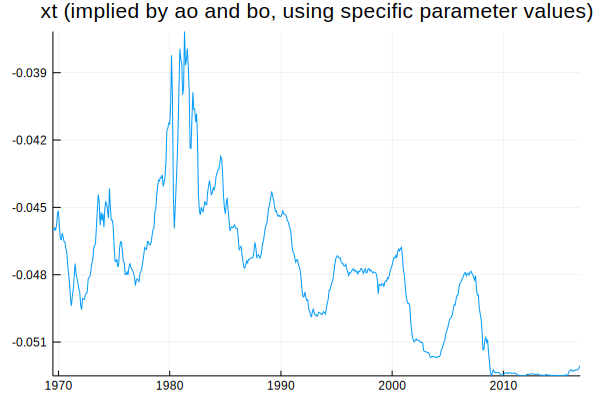

In [6]:
xTicksLoc = Dates.value.(Date(1970):Dates.Year(10):Date(2010))
xTicksLab = ["1970";"1980";"1990";"2000";"2010"]               #crude way of getting the tick marks right

plot(dN,xt,legend=false,xticks=(xTicksLoc,xTicksLab))
title!("xt (implied by ao and bo, using specific parameter values)")

## The Likelihood Function

To formulate the log-liklihood, the VasicekTsCsFn
first takes the parameter vectors and transforms the parameters (scaling,
making sure that $-1\leq\rho\leq1$, etc) and the calls on the function
VasicekABFn (see above).


From the previous output, the code in VasicekTsCsFn moves on to
define the 1-step ahead forecast errors of $y_{ot}$ as

$
v_{t}=y_{ot}-\text{E}_{t-1}y_{ot}
$

and its variance $S=b_{o}^{\prime}\sigma^{2}b_{o}$. The contribution to the
likelihood function in $t$ is proportional to $v_{t}^{\prime}S^{-1}v_{t}$.
Then, the code defines the cross-sectional errors (for $y_{ut}$) as

$
u_{t}=y_{ut}-\hat{y}_{ut} \: \text{, where } \: \hat{y}_{ut}=a_{u}+b_{u}^{\prime}x_{t},
$

The contribution to the likelihood function is $u_{t}^{\prime}\Omega^{-1}
u_{t}$, where the code assumes that $\Omega$ is diagonal,
$
\Omega=I\omega^{2},
$
where $\omega$ is one of the parameters estimated. 

The function VasicekTsCsLossFn creates
the value of the function that will be minimized.

In [7]:
function VasicekTsCsFn(par,yo,yu,nMo,nMu)
#VasicekTsCsFn    Loss function for estimating the Vasicek model using both
#                 time series and cross sectional information

  J = length(nMu)
  T = size(yo,1)

  lambda  = par[1]*100
  mu      = par[2]/1200
  p       = 1 - 2/(1+exp(par[3]))          #inverse: par[3] = log((1+p)/(1-p))
  s2      = (par[4]/1200)^2
  omega_i = abs(par[5]/1200)

  if length(nMo) != 1
    error("yo must be a single yield")
  end

  (ao,bo,xt,au,bu,yuHat) = VasicekABFn(lambda,mu,p,sqrt(s2),nMo,nMu,yo)

  Et1xt    = (1-p)*mu .+ p*[NaN;xt[1:end-1]]   #E(t-1)x(t)
  Et1xt[1] = mu
  Et1yo    = ao .+ Et1xt*bo             #E(t-1)yo(t)
  v        = yo - Et1yo                 #Tx1, forecast error of yo
  S        = bo's2*bo                   #variance of forecast error of yo
  S_1      = inv(S*1000)*1000           #1000/1000 improves the precision a bit
  
  LLo_t    = fill(-0.5*log(2*pi) - 0.5*log(det(S)),T)
  for t = 1:T
    LLo_t[t] = LLo_t[t] - 0.5*v[t,:]'S_1*v[t,:]
  end      

  u        = yu - yuHat                  #TxL, fitted errors of yu
  Omega    = Matrix(1.0I,J,J)*omega_i^2  #Matrix(1.0I,J,J) is I(J)
  Omega_1  = inv(Omega)                  #covariance matrix of u
  
  LLu_t    = fill(-0.5*J*log(2*pi) .- 0.5*log(det(Omega)),T)
  for t = 1:T  
    LLu_t[t] = LLu_t[t] - 0.5*u[t,:]'Omega_1*u[t,:]
  end      
    

  LL_t    = LLo_t + LLu_t                #Tx1, log likelihood(t), sum of TS and CS
  
  return LL_t,yuHat,u,xt

end


function VasicekTsCsLossFn(par,yo,yu,nMo,nMu)
  LL_t,   = VasicekTsCsFn(par,yo,yu,nMo,nMu)
  MinusLL = -sum(LL_t[2:end])            #to be minimized 
  return MinusLL
end

VasicekTsCsLossFn (generic function with 1 method)

## Trying the Loss Function

In [8]:
#notice: important that the elements of the parameter vector have similar magnitude
#lambda/100,mu*1200,p = 1 - 2/(1+exp(par(3))) so 5.6 -> p = 0.993,sigma*1200,omega*1200
par0 = [-2.3,10,5.5,0.5,0.8]

MinusLL = VasicekTsCsLossFn(par0,yo,yu,nMo,nMu)

printlnPs("The negative of the log-likelihood function at the starting guess: ",MinusLL)

The negative of the log-likelihood function at the starting guess: -23764.802


## Minimizing the Loss Function

In [9]:
Sol = optimize(par->VasicekTsCsLossFn(par,yo,yu,nMo,nMu),par0)
par1 = Optim.minimizer(Sol)

println("\nStarting guess   estimate")
printmat([par0 par1])

#converting back to model parameters 
(lambda,mu,rho,s2) = (par1[1]*100,par1[2]/1200,1 - 2/(1+exp(par1[3])),par1[4]/1200)
println("Estimated (lambda,mu,rho,s2):")
printmat([lambda mu rho s2])


Starting guess   estimate
    -2.300    -2.475
    10.000     9.270
     5.500     5.856
     0.500     0.502
     0.800     0.779

Estimated (lambda,mu,rho,s2):
  -247.453     0.008     0.994     0.000



In [10]:
MinusLL = VasicekTsCsLossFn(par1,yo,yu,nMo,nMu)
println("The negative of the log-likelihood function at the point estimate: ",MinusLL)

(LL_t,yuHat,u,xt) = VasicekTsCsFn(par1,yo,yu,nMo,nMu)

yhatTsCs = [yo yuHat]                      #fitted yields

                                            #average yield curve
(ao,bo,xt,au,bu,yuHatAvg) = VasicekABFn(lambda,mu,rho,s2,nMo,nMu,mean(yo))
yuHatAvg = [mean(yo) yuHatAvg]             #also yo

println()

The negative of the log-likelihood function at the point estimate: -23860.91915371981



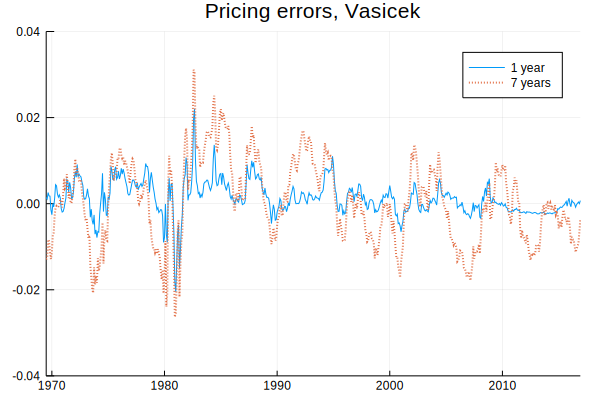

In [11]:
yy = y[:,[3,6]] - yhatTsCs[:,[3,6]]  

plot(dN,12*yy[:,1],label="1 year")
plot!(dN,12*yy[:,2],line=(:dot,2),label="7 years")
plot!(ylims=(-0.04,0.04),xticks=(xTicksLoc,xTicksLab))
title!("Pricing errors, Vasicek")

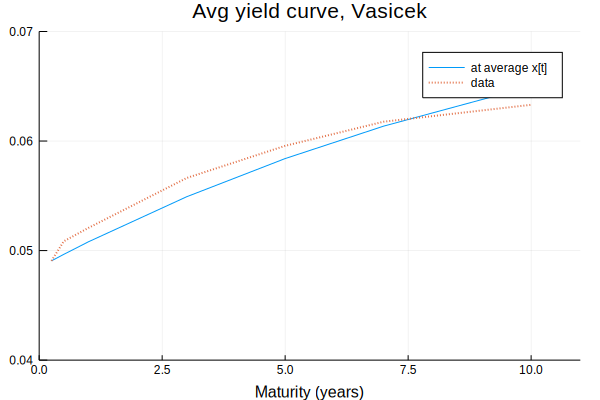

In [12]:
plot(m',12*yuHatAvg',label="at average x[t] ")
plot!(m',12*mean(y,1)',line=(:dot,2),label="data")
plot!(xlims=(0,11),ylims=(0.04,0.07))
title!("Avg yield curve, Vasicek")
xlabel!("Maturity (years)")

## Comparing Vasicek Results to OLS 

by regressing all yields on just the short yield.

In [13]:
bOls = [ones(T) y[:,1]]\y                 #LS of yields on short yield
alfa = bOls[1:1,:]
beta = bOls[2:2,:]
                         #rescaling Vasicek au and bu to be comaparable with OLS on yo
bu_b = bu/bo             #y = au + bu*xt, but xt = (yo-ao)/bo
au_b = au - bu/bo*ao     #y = au + bu*(yo-ao)/bo = y = au - bu*ao/bo + bu/bo*yo
bu_b = [1 bu_b]          #also yo
au_b = [0 au_b]

println()

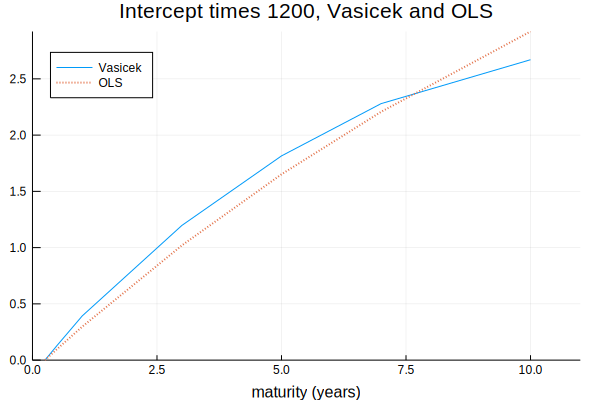

In [14]:
plot(m',alfa'*1200,label="Vasicek")
plot!(m',au_b'*1200,line=(:dot,2),label="OLS")
plot!(xlims=(0,maximum(m)+1),legend=:topleft)
title!("Intercept times 1200, Vasicek and OLS")
xlabel!("maturity (years)")

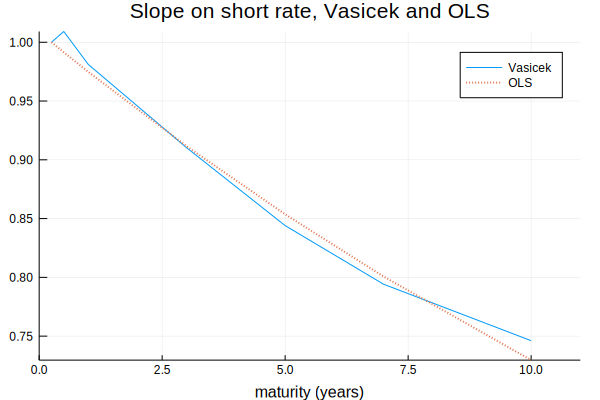

In [15]:
plot(m',beta',label="Vasicek")
plot!(m',bu_b',line=(:dot,2),label="OLS")
plot!(xlims=(0,maximum(m)+1))
title!("Slope on short rate, Vasicek and OLS")
xlabel!("maturity (years)")